In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(BBmisc))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

# Lockdown dates

In [4]:
periods <- list(
    # lockdown
    lockdown = ymd("2020-03-14"),
    #end.lockdown = as.numeric(ymd_hms("2020-04-28 00:00:00")),

    # poslockdown
    fases = ymd("2020-05-01"),
    normalidad = ymd("2020-06-21"),

    # New lockdown
    new.lockdown = ymd("2020-10-25")
)

## Load Data

In [5]:
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site == "es1580a",
                   variable == "no2") %>%
            timeAverage(avg.time = "day", type="variable")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es1580a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)

In [6]:
df.data <- df %>%
        select(-date, -variable) %>% 
        normalize(method = "range", 
                  range = c(0, 1), margin = 1) %>% 
        data.frame()
time <- df$date

In [7]:
head(df.data)

,value,ws,wd,atmos_pres,tmed,prec,tmin,tmax,presMax,presMin,RH,solar.radiation
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1372987,0.5228938,0.7965202,0.6391435,0.3473282,0.06425234,0.5000000,0.2500000,0.7115750,0.6231454,0.7956335,0.1971665
2,0.4789803,0.3342491,0.9295643,0.8253333,0.3320611,0.00817757,0.4649123,0.2467105,0.8842505,0.8056380,0.7649737,0.1446565
3,0.3922182,0.2738095,0.2910489,0.9347022,0.3167939,0.00000000,0.4035088,0.2697368,0.9203036,0.9406528,0.7420789,0.1120629
4,0.4776386,0.1703297,0.3468069,0.9355108,0.3396947,0.00000000,0.3859649,0.3190789,0.9316888,0.9540059,0.7041838,0.2058308
5,0.3881932,0.1309524,0.3464925,0.9028763,0.2519084,0.00000000,0.3728070,0.1809211,0.9032258,0.9243323,0.8251392,0.2274834
6,0.2052773,0.1804029,0.3041984,0.8360479,0.3053435,0.00000000,0.3859649,0.2631579,0.8652751,0.8471810,0.8342027,0.2205552


In [8]:
train <-  which(time < ymd("2020-01-01"))
test <- which(time > ymd("2020-01-01"))

## Analysis

In [9]:
fit.th <- lm(value ~., data = df.data, subset=train)

y.th <- predict(fit.th, newdata = df.data[test,], 
                interval="confidence", level = 0.95)

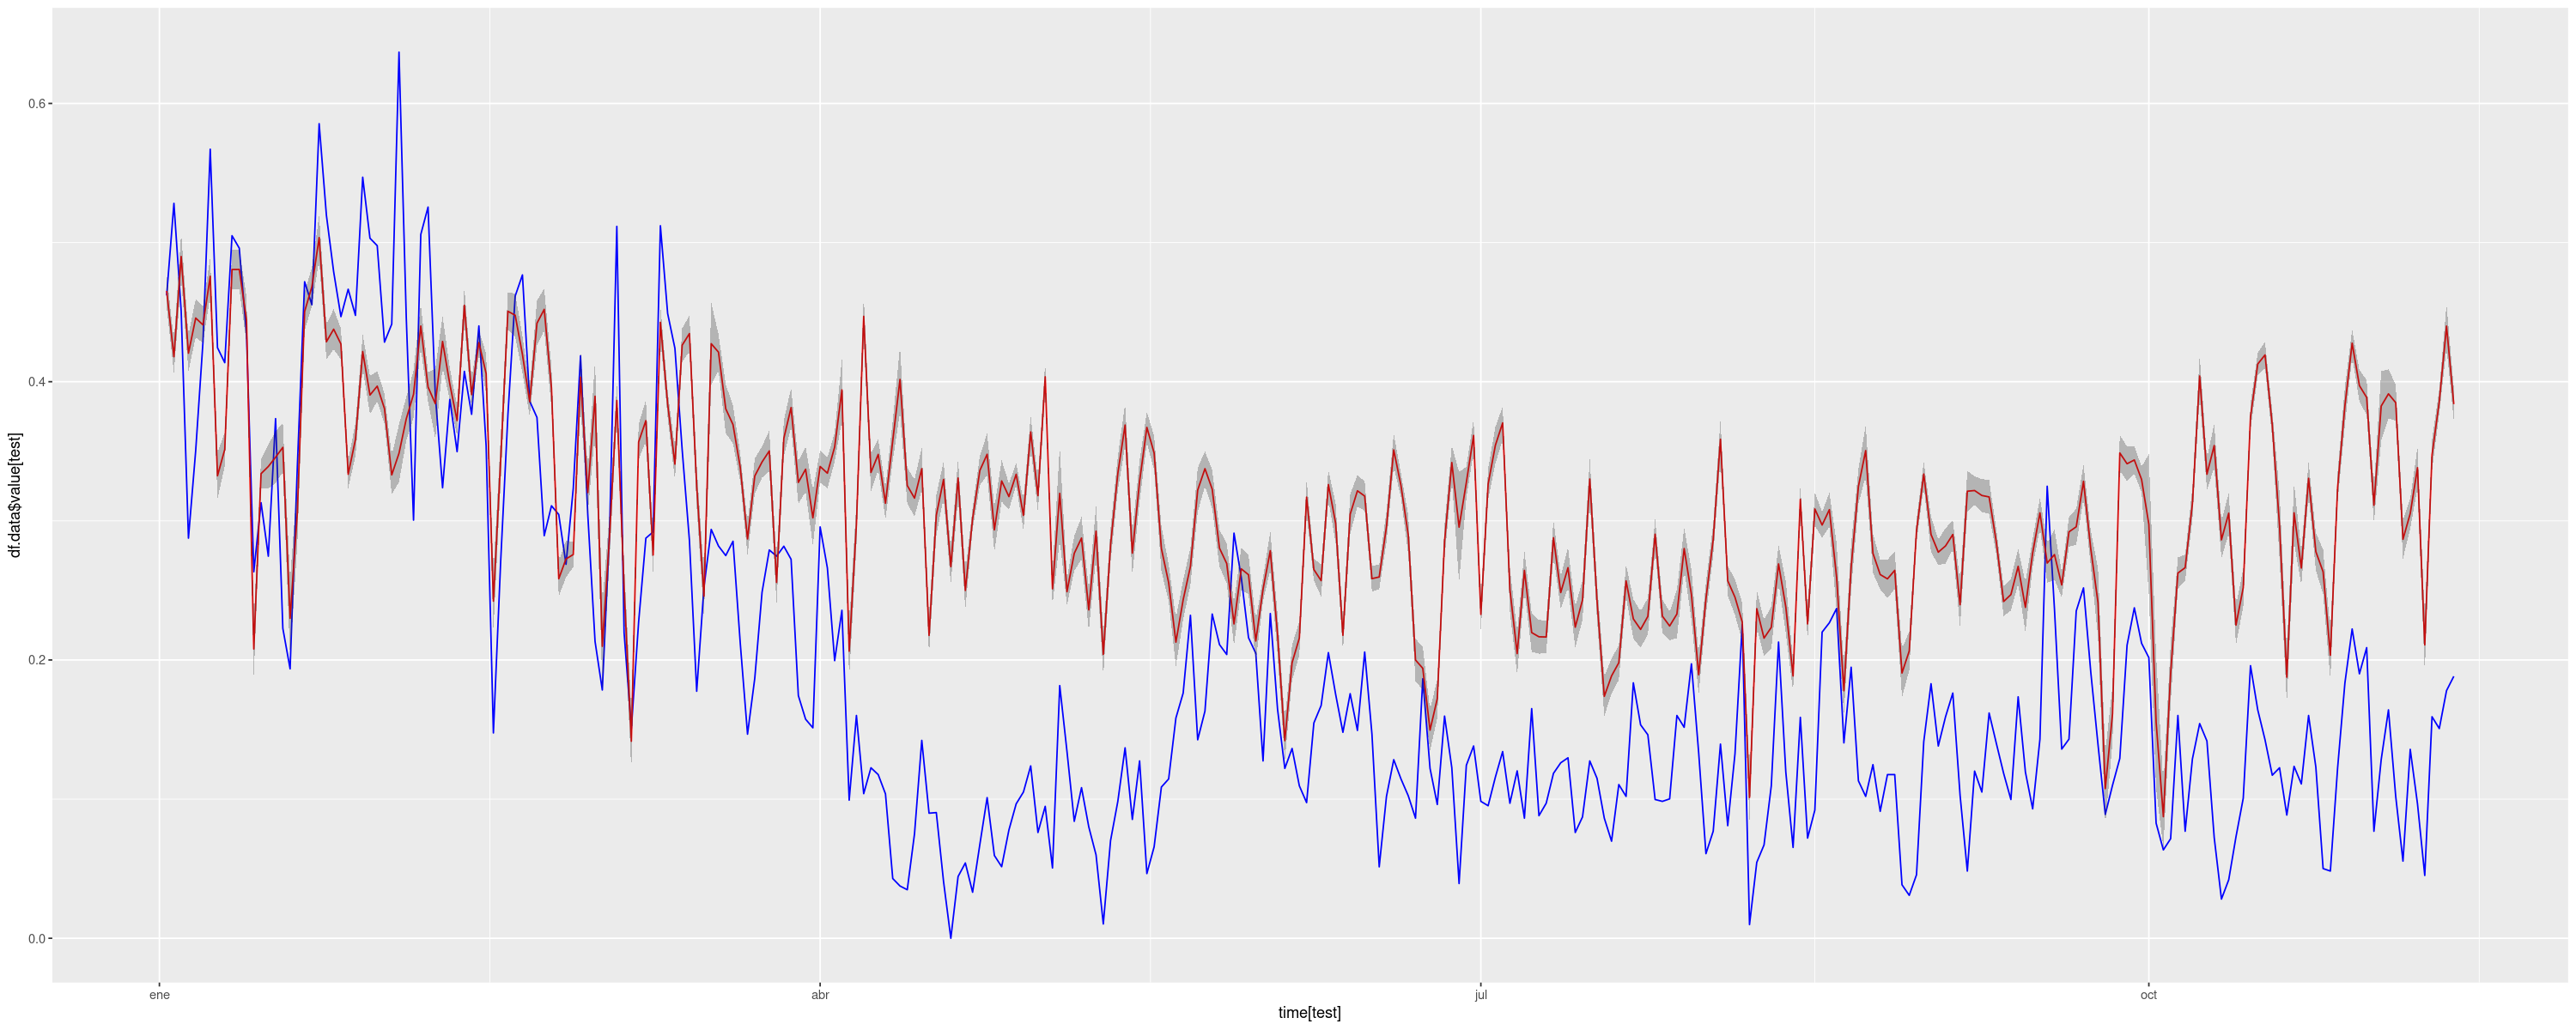

In [10]:
ggplot() +
    geom_line(aes(x = time[test], y = df.data$value[test]), color="blue") +
    geom_line(aes(x = time[test], y = y.th[,1]), color="red") +
    geom_ribbon(aes(x = time[test],
                    ymin=y.th[,2], ymax=y.th[,3]),
                alpha=0.3)

## Using `segmented` package

In [11]:
suppressMessages(library(segmented))

var <- data.frame(y = (df.data$value[test] - y.th[, 1] ),
                  x = as.numeric(time[test]))

my.seg <- segmented(lm(y ~ x, data=var), 
                      seg.Z = ~ x,
                      psi = unlist(periods)
                     )

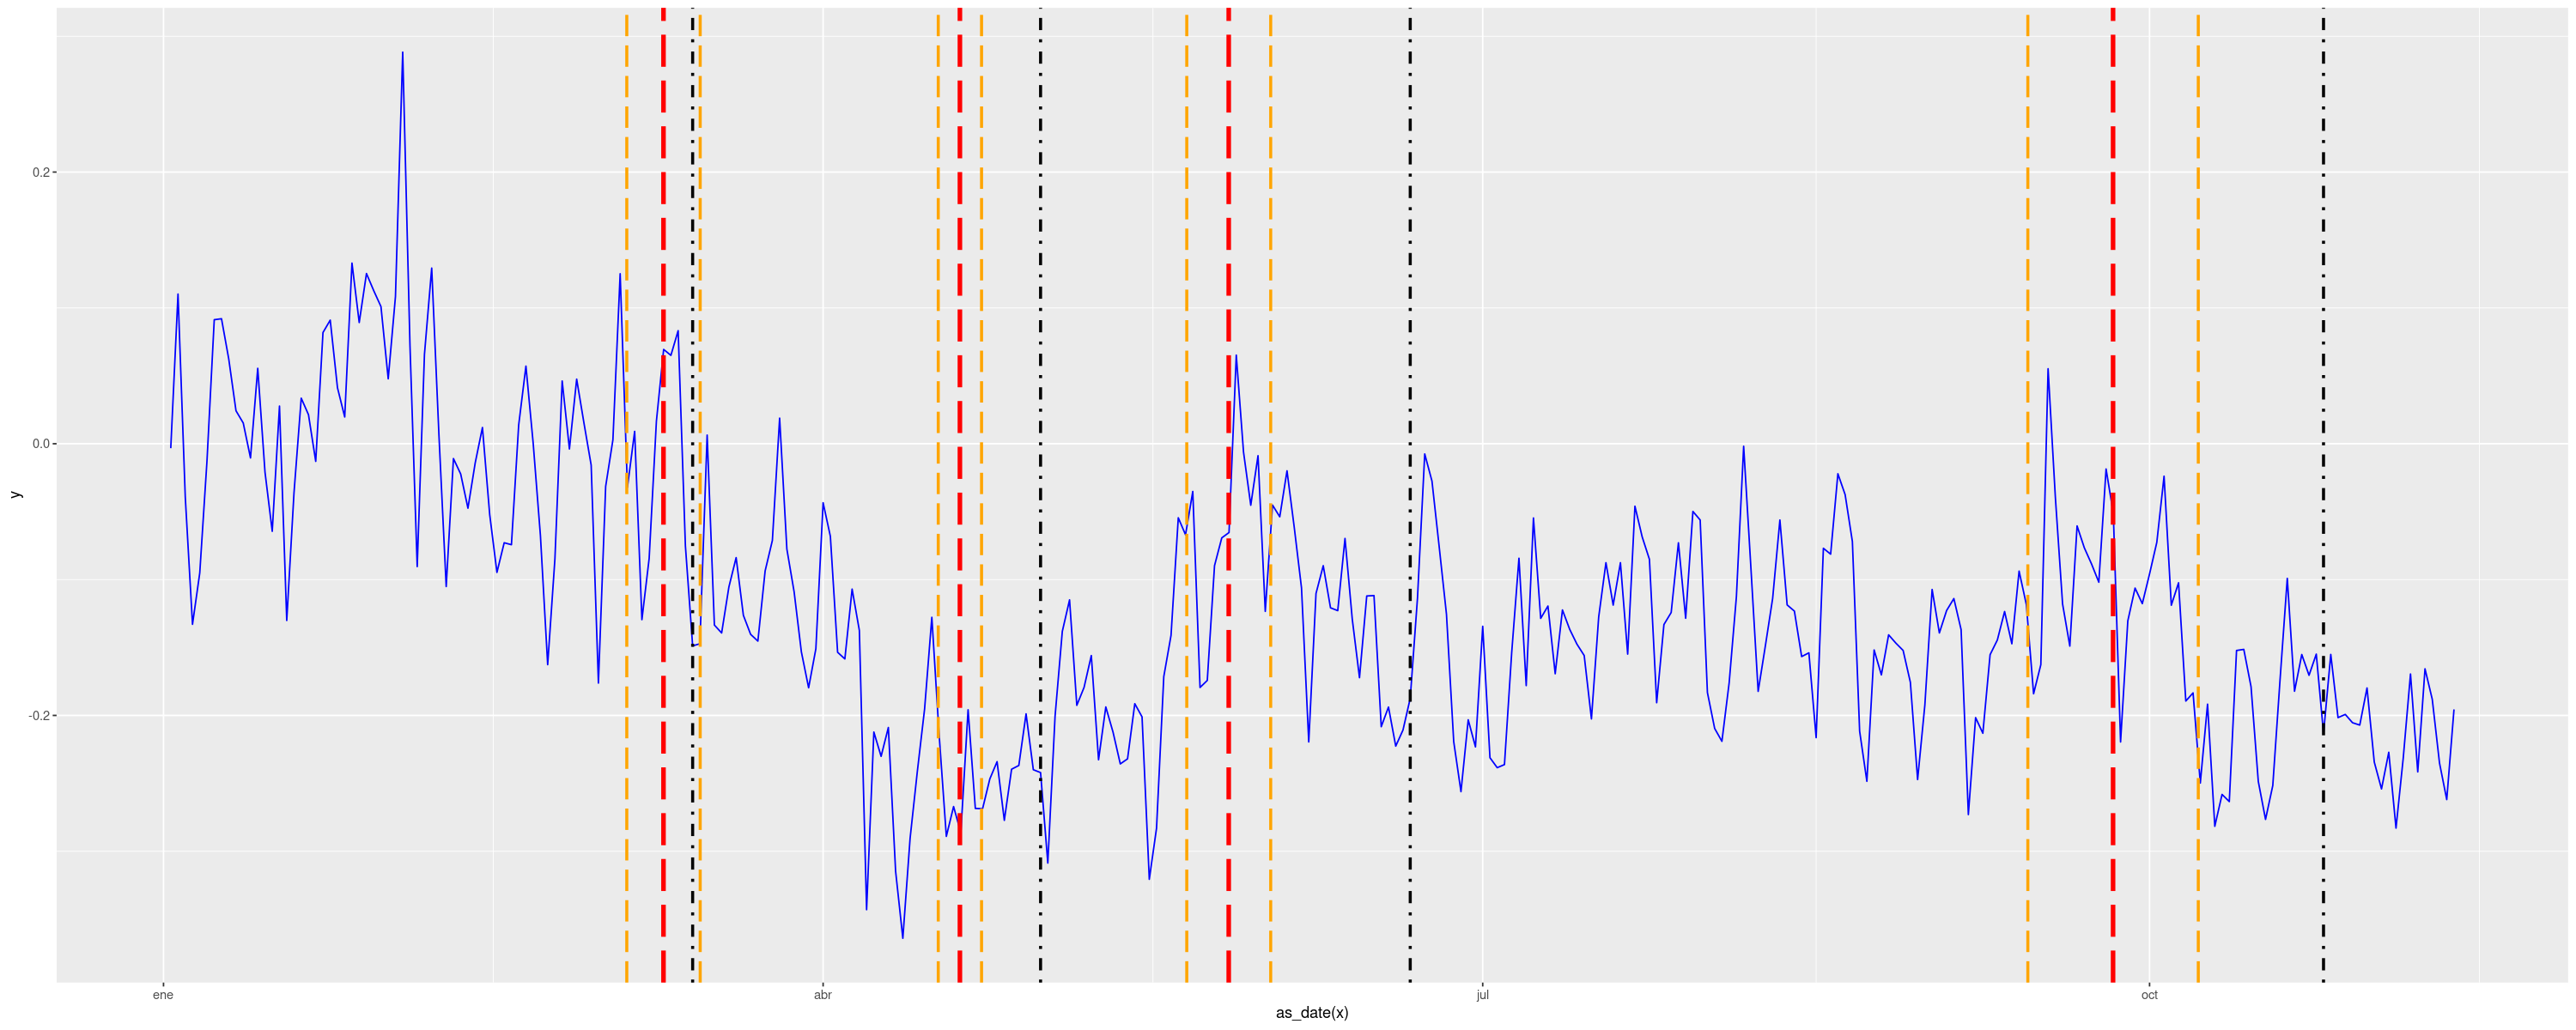

In [12]:
plot <- ggplot(data=var, aes(x=as_date(x)))+ 
    geom_line(aes(y=y), color="blue", size=0.5)

if (length(my.seg$psi) != 0) {
    for (k in 1:(nrow(my.seg$psi))) {
        plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."], 
                                  linetype=5, color = "red", size=1.5)
        plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."] - my.seg$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
        plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."] + my.seg$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
    }
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot

In [13]:
for (i in 1:nrow(my.seg$psi)) {
print(paste(as_date(my.seg$psi[i, "Initial"]), 
            as_date(my.seg$psi[i, "Est."]), sep=" =>"))
}

[1] "2020-03-14 =>2020-03-09"
[1] "2020-05-01 =>2020-04-19"
[1] "2020-06-21 =>2020-05-26"
[1] "2020-10-25 =>2020-09-25"


In [14]:
d <- data.frame()

a <- which(var$x < my.seg$psi[1, "Est."])
    
    modl <- lm(y ~ x + 1, data=var[a, ])
    
    d <- rbind(d,
               data.frame(i=as.factor(1),
                          x = var[a, "x"],
                          obs=var[a, "y"],
                          fit= modl$coefficients[1] + modl$coefficients[2]*var[a, "x"]
                         ))

for (i in 2:nrow(my.seg$psi)) {
    a <- which(var$x < my.seg$psi[i, "Est."] &
               var$x > my.seg$psi[i-1, "Est."])
    
    modl <- lm(y ~ x + 1, data=var[a, ])
    
    d <- rbind(d,
               data.frame(i=as.factor(i),
                          x = var[a, "x"],
                          obs=var[a, "y"],
                          fit= modl$coefficients[1] + modl$coefficients[2]*var[a, "x"]
                         ))
}

a <- which(var$x > my.seg$psi[nrow(my.seg$psi), "Est."])
    
    modl <- lm(y ~ x + 1, data=var[a, ])
    
    d <- rbind(d,
               data.frame(i=as.factor(5),
                          x = var[a, "x"],
                          obs=var[a, "y"],
                          fit= modl$coefficients[1] + modl$coefficients[2]*var[a, "x"]
                         ))

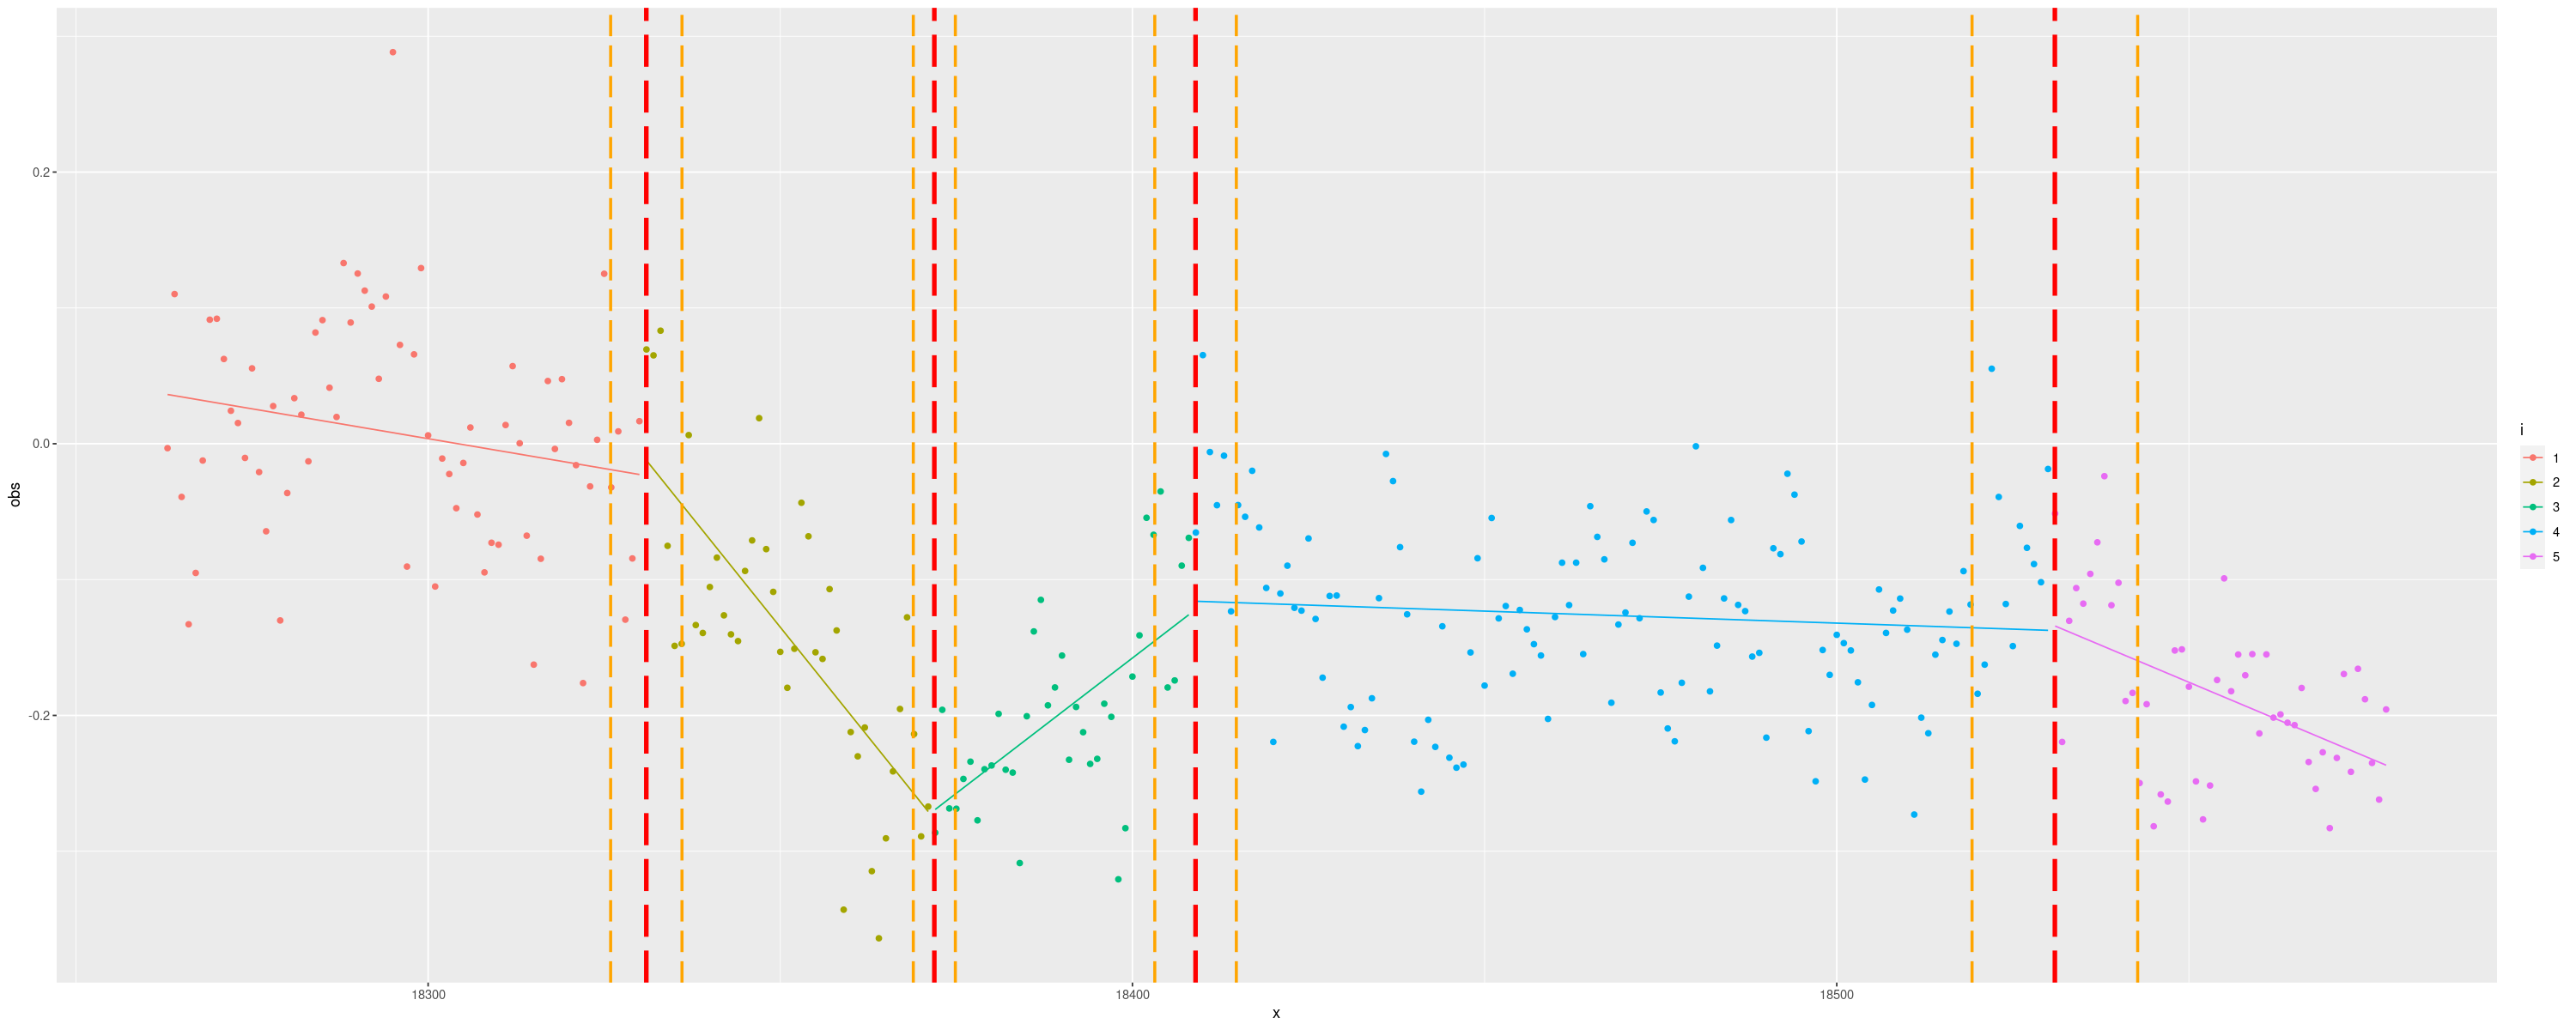

In [15]:
plot <- ggplot(d, aes(x=x)) +
    geom_point(aes(y=obs, color=i)) +
    geom_line(aes(y=fit, color=i))

if (length(my.seg$psi) != 0) {
    for (k in 1:(nrow(my.seg$psi))) {
        plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."], 
                                  linetype=5, color = "red", size=1.5)
        plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."] - my.seg$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
        plot <- plot + geom_vline(xintercept = my.seg$psi[k,"Est."] + my.seg$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
    }
}
plot